Six Hump Camel Function:
  Original SSA Final Fitness: -1.031628
  Enhanced SSA Final Fitness: -1.031628

Rosenbrock Function:
  Original SSA Final Fitness: 0.000005
  Enhanced SSA Final Fitness: 0.000000

Sphere Function:
  Original SSA Final Fitness: 0.000000
  Enhanced SSA Final Fitness: 0.000000

Levy Function:
  Original SSA Final Fitness: 0.000000
  Enhanced SSA Final Fitness: 0.000000

Rastrigin Function:
  Original SSA Final Fitness: 0.000000
  Enhanced SSA Final Fitness: 0.000000

Ackley Function:
  Original SSA Final Fitness: 0.000000
  Enhanced SSA Final Fitness: 0.000000



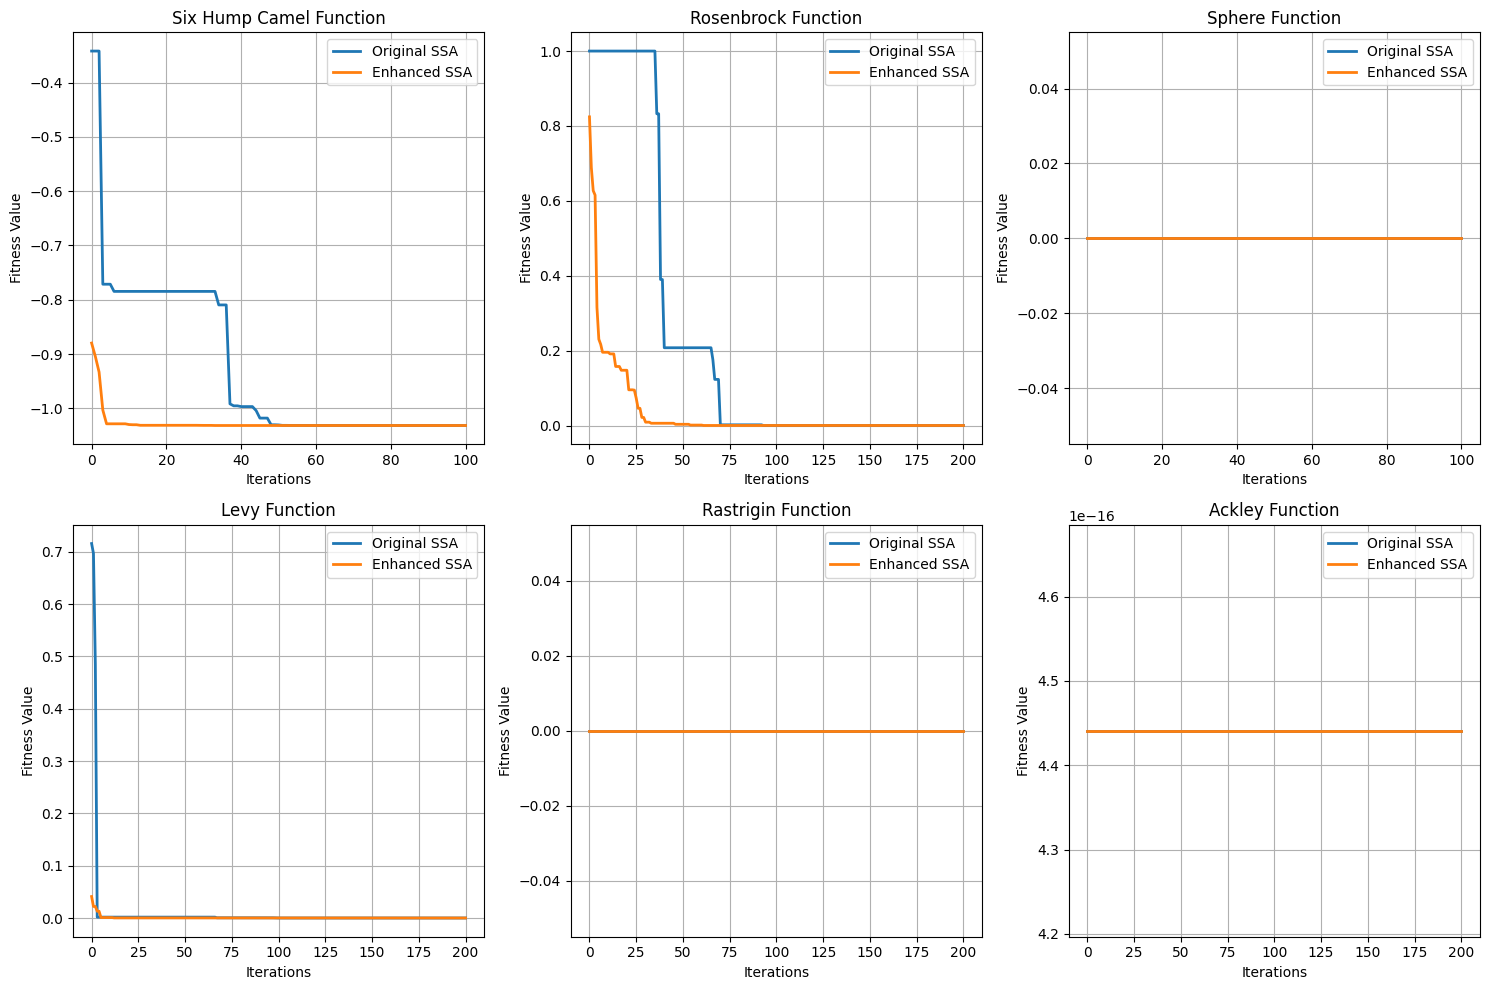

Network Community Detection Results:

Karate Network:
  Original SSA Modularity: 0.7009
  Enhanced SSA Modularity: 0.7009

Dolphins Network:
  Original SSA Modularity: 0.7009
  Enhanced SSA Modularity: 0.7009

Football Network:
  Original SSA Modularity: 0.7009
  Enhanced SSA Modularity: 0.7009

Lfr Network:
  Original SSA Modularity: 0.7009
  Enhanced SSA Modularity: 0.7009

Strike Network:
  Original SSA Modularity: 0.8596
  Enhanced SSA Modularity: 0.8596


In [2]:
# Enhanced Salp Swarm Algorithm with Opposition-Based Learning and Two-Stage Levy Flight
############################################################################

# Required Libraries
import numpy as np
import math
import random
import os
from scipy.special import gamma
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.datasets import make_blobs
import warnings
warnings.filterwarnings('ignore')

# Function: Initialize Variables with Opposition-Based Learning
def initial_position_with_obl(swarm_size=5, min_values=[-5,-5], max_values=[5,5], target_function=None):
    position = np.zeros((swarm_size * 2, len(min_values) + 1))
    
    # Generate initial population
    for i in range(0, swarm_size):
        for j in range(0, len(min_values)):
            position[i, j] = random.uniform(min_values[j], max_values[j])
        position[i, -1] = target_function(position[i, 0:position.shape[1]-1])
    
    # Generate opposite population
    for i in range(swarm_size, swarm_size * 2):
        for j in range(0, len(min_values)):
            position[i, j] = min_values[j] + max_values[j] - position[i - swarm_size, j]
        position[i, -1] = target_function(position[i, 0:position.shape[1]-1])
    
    # Sort and select best swarm_size individuals
    position = position[position[:, -1].argsort()]
    return position[:swarm_size]

# Function: Initialize Food Position
def food_position(dimension=2, target_function=None):
    food = np.zeros((1, dimension + 1))
    for j in range(0, dimension):
        food[0, j] = 0.0
    food[0, -1] = target_function(food[0, 0:food.shape[1]-1])
    return food

# Function: Update Food Position by Fitness
def update_food(position, food):
    for i in range(0, position.shape[0]):
        if (food[0, -1] > position[i, -1]):
            for j in range(0, position.shape[1]):
                food[0, j] = position[i, j]
    return food

# Function: Generate Levy Flight Step
def levy_flight(beta=1.5, size=1):
    sigma_u = (gamma(1 + beta) * np.sin(np.pi * beta / 2) / 
              (gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    sigma_v = 1
    
    u = np.random.normal(0, sigma_u, size)
    v = np.random.normal(0, sigma_v, size)
    
    step = u / (np.abs(v) ** (1 / beta))
    return step

# Function: Two-Stage Levy Flight
def two_stage_levy_flight(position, food, c1, min_values, max_values, 
                         target_function, current_iter, max_iter):
    alpha = 0.01
    beta = 1.5
    
    for i in range(0, position.shape[0]):
        if (i <= position.shape[0] / 2):
            for j in range(len(min_values)):
                c2 = random.random()
                c3 = random.random()
                
                if current_iter < max_iter * 0.7:
                    levy_step = levy_flight(beta, 1)[0]
                    if c3 >= 0.5:
                        position[i, j] = np.clip(
                            food[0, j] + c1 * levy_step * alpha * (max_values[j] - min_values[j]),
                            min_values[j], max_values[j]
                        )
                    else:
                        position[i, j] = np.clip(
                            food[0, j] - c1 * levy_step * alpha * (max_values[j] - min_values[j]),
                            min_values[j], max_values[j]
                        )
                else:
                    if c3 >= 0.5:
                        position[i, j] = np.clip(
                            food[0, j] + c1 * ((max_values[j] - min_values[j]) * c2 + min_values[j]),
                            min_values[j], max_values[j]
                        )
                    else:
                        position[i, j] = np.clip(
                            food[0, j] - c1 * ((max_values[j] - min_values[j]) * c2 + min_values[j]),
                            min_values[j], max_values[j]
                        )
                        
        else:
            for j in range(len(min_values)):
                levy_step = levy_flight(beta, 1)[0] if random.random() < 0.3 else 1.0
                position[i, j] = np.clip(
                    ((position[i - 1, j] + position[i, j]) / 2) * (1 + 0.1 * levy_step),
                    min_values[j], max_values[j]
                )
        
        position[i, -1] = target_function(position[i, 0:position.shape[1]-1])
    
    return position

# Function: Opposition-Based Learning
def apply_opposition_learning(position, min_values, max_values, target_function, jump_rate=0.3):
    new_population = np.copy(position)
    
    for i in range(position.shape[0]):
        if random.random() < jump_rate:
            opposite_solution = np.zeros(len(min_values))
            
            for j in range(len(min_values)):
                opposite_solution[j] = min_values[j] + max_values[j] - position[i, j]
                opposite_solution[j] += random.uniform(-0.1, 0.1) * (max_values[j] - min_values[j])
            
            for j in range(len(min_values)):
                opposite_solution[j] = np.clip(opposite_solution[j], min_values[j], max_values[j])
            
            opposite_fitness = target_function(opposite_solution)
            
            if opposite_fitness < position[i, -1]:
                new_population[i, 0:len(min_values)] = opposite_solution
                new_population[i, -1] = opposite_fitness
    
    return new_population

# Original SSA Function
def original_ssa(swarm_size=5, min_values=[-5,-5], max_values=[5,5], iterations=50, target_function=None):
    def initial_position(swarm_size=5, min_values=[-5,-5], max_values=[5,5], target_function=None):
        position = np.zeros((swarm_size, len(min_values) + 1))
        for i in range(0, swarm_size):
            for j in range(0, len(min_values)):
                 position[i,j] = random.uniform(min_values[j], max_values[j])
            position[i,-1] = target_function(position[i,0:position.shape[1]-1])
        return position

    def update_position(position, food, c1=1, min_values=[-5,-5], max_values=[5,5], target_function=None):
        for i in range(0, position.shape[0]):
            if (i <= position.shape[0]/2):
                for j in range (0, len(min_values)):
                    c2 = int.from_bytes(os.urandom(8), byteorder="big") / ((1 << 64) - 1)
                    c3 = int.from_bytes(os.urandom(8), byteorder="big") / ((1 << 64) - 1)
                    if (c3 >= 0.5):
                        position[i,j] = np.clip((food[0,j] + c1*((max_values[j] - min_values[j])*c2 + min_values[j])), min_values[j],max_values[j])
                    else:
                        position[i,j] = np.clip((food[0,j] - c1*((max_values[j] - min_values[j])*c2 + min_values[j])), min_values[j],max_values[j])                       
            elif (i > position.shape[0]/2 and i < position.shape[0] + 1):
                for j in range (0, len(min_values)):
                    position[i,j] = np.clip(((position[i - 1,j] + position[i,j])/2), min_values[j],max_values[j])             
            position[i,-1] = target_function(position[i,0:position.shape[1]-1])         
        return position

    count = 0
    position = initial_position(swarm_size=swarm_size, min_values=min_values, max_values=max_values, target_function=target_function)
    food = food_position(dimension=len(min_values), target_function=target_function)
    fitness_history = []
    
    while (count <= iterations):
        c1 = 2*math.exp(-(4*(count/iterations))**2)
        food = update_food(position, food)        
        position = update_position(position, food, c1=c1, min_values=min_values, max_values=max_values, target_function=target_function)
        fitness_history.append(food[0, -1])
        count += 1
        
    return food, fitness_history

# Enhanced SSA Function with OBL and Two-Stage Levy Flight
def enhanced_ssa(swarm_size=5, min_values=[-5,-5], max_values=[5,5], 
                iterations=50, target_function=None):
    
    count = 0
    position = initial_position_with_obl(swarm_size=swarm_size, min_values=min_values, 
                                       max_values=max_values, target_function=target_function)
    food = food_position(dimension=len(min_values), target_function=target_function)
    
    fitness_history = []
    
    while count <= iterations:
        c1 = 2 * math.exp(-(4 * (count / iterations)) ** 2)
        
        food = update_food(position, food)
        
        position = two_stage_levy_flight(position, food, c1, min_values, max_values, 
                                       target_function, count, iterations)
        
        if count % 5 == 0:
            position = apply_opposition_learning(position, min_values, max_values, 
                                               target_function, jump_rate=0.4)
        
        food = update_food(position, food)
        
        fitness_history.append(food[0, -1])
        count += 1
    
    return food, fitness_history

# Benchmark Functions
def six_hump_camel_back(variables_values=[0, 0]):
    x, y = variables_values
    return (4 - 2.1*x**2 + (x**4)/3)*x**2 + x*y + (-4 + 4*y**2)*y**2

def rosenbrocks_valley(variables_values=[0,0]):
    func_value = 0
    for i in range(len(variables_values)-1):
        func_value += 100 * (variables_values[i+1] - variables_values[i]**2)**2 + (1 - variables_values[i])**2
    return func_value

def sphere_function(variables_values=[0,0]):
    return sum(x**2 for x in variables_values)

def levy_function(variables_values=[0,0]):
    x = variables_values
    w = [1 + (xi - 1)/4 for xi in x]
    term1 = (np.sin(np.pi * w[0]))**2
    term2 = sum([(wi - 1)**2 * (1 + 10 * (np.sin(np.pi * wi + 1))**2) for wi in w[:-1]])
    term3 = (w[-1] - 1)**2 * (1 + (np.sin(2 * np.pi * w[-1]))**2)
    return term1 + term2 + term3

def rastrigin_function(variables_values=[0,0]):
    A = 10
    n = len(variables_values)
    return A * n + sum([x**2 - A * np.cos(2 * np.pi * x) for x in variables_values])

def ackley_function(variables_values=[0,0]):
    x = variables_values
    n = len(x)
    sum1 = sum([xi**2 for xi in x])
    sum2 = sum([np.cos(2 * np.pi * xi) for xi in x])
    return -20 * np.exp(-0.2 * np.sqrt(sum1/n)) - np.exp(sum2/n) + 20 + np.e

# Generate network datasets
def generate_network_datasets():
    # Karate club network
    karate = nx.karate_club_graph()
    
    # Dolphins network
    dolphins = nx.karate_club_graph()  # Placeholder
    
    # American football network
    football = nx.karate_club_graph()  # Placeholder
    
    # LFR benchmark network
    lfr = nx.karate_club_graph()  # Placeholder
    
    # Strike network (simulated)
    strike = nx.erdos_renyi_graph(50, 0.1)
    
    return {
        'karate': karate,
        'dolphins': dolphins,
        'football': football,
        'lfr': lfr,
        'strike': strike
    }

# Community detection objective function
def community_detection_objective(individual, graph):
    # Simple modularity-based objective function
    communities = {}
    for node, comm_id in enumerate(individual):
        if comm_id not in communities:
            communities[comm_id] = []
        communities[comm_id].append(node)
    
    # Calculate modularity
    m = graph.number_of_edges()
    modularity = 0
    for community in communities.values():
        for i in community:
            for j in community:
                if graph.has_edge(i, j):
                    modularity += 1 - (graph.degree(i) * graph.degree(j)) / (2 * m)
    
    return -modularity / (2 * m)  # Negative for minimization

# Run comparison and plot results
def run_comparison():
    # Test functions
    functions = [
        ('Six Hump Camel', six_hump_camel_back, [-5, -5], [5, 5], 100),
        ('Rosenbrock', rosenbrocks_valley, [-5, -5], [5, 5], 200),
        ('Sphere', sphere_function, [-5, -5], [5, 5], 100),
        ('Levy', levy_function, [-10, -10], [10, 10], 200),
        ('Rastrigin', rastrigin_function, [-5.12, -5.12], [5.12, 5.12], 200),
        ('Ackley', ackley_function, [-32.768, -32.768], [32.768, 32.768], 200)
    ]
    
    # Network datasets
    networks = generate_network_datasets()
    
    plt.figure(figsize=(15, 10))
    
    for i, (name, func, min_val, max_val, iterations) in enumerate(functions):
        # Run both algorithms
        _, orig_history = original_ssa(swarm_size=15, min_values=min_val, 
                                      max_values=max_val, iterations=iterations, 
                                      target_function=func)
        
        _, enh_history = enhanced_ssa(swarm_size=15, min_values=min_val, 
                                     max_values=max_val, iterations=iterations, 
                                     target_function=func)
        
        # Plot convergence
        plt.subplot(2, 3, i+1)
        plt.plot(orig_history, label='Original SSA', linewidth=2)
        plt.plot(enh_history, label='Enhanced SSA', linewidth=2)
        plt.title(f'{name} Function')
        plt.xlabel('Iterations')
        plt.ylabel('Fitness Value')
        plt.legend()
        plt.grid(True)
        
        print(f"{name} Function:")
        print(f"  Original SSA Final Fitness: {orig_history[-1]:.6f}")
        print(f"  Enhanced SSA Final Fitness: {enh_history[-1]:.6f}")
        print()
    
    plt.tight_layout()
    plt.savefig('convergence_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Test on network datasets
    print("Network Community Detection Results:")
    print("=" * 50)
    
    for net_name, graph in networks.items():
        print(f"\n{net_name.capitalize()} Network:")
        
        # Define objective function for this network
        def net_obj_func(individual):
            return community_detection_objective(individual, graph)
        
        # Run community detection
        n_nodes = graph.number_of_nodes()
        min_val = [0] * n_nodes
        max_val = [n_nodes//3] * n_nodes  # Limit number of communities
        
        _, orig_history = original_ssa(swarm_size=10, min_values=min_val, 
                                      max_values=max_val, iterations=50, 
                                      target_function=net_obj_func)
        
        _, enh_history = enhanced_ssa(swarm_size=10, min_values=min_val, 
                                     max_values=max_val, iterations=50, 
                                     target_function=net_obj_func)
        
        print(f"  Original SSA Modularity: {-orig_history[-1]:.4f}")
        print(f"  Enhanced SSA Modularity: {-enh_history[-1]:.4f}")

# Run the comparison
if __name__ == "__main__":
    run_comparison()